#### Analyzing Neural Time Series Data
Python code for Chapter 2 -- converted from original Matlab by AE Studio (and ChatGPT)\
Original Matlab code by Mike X Cohen

This code accompanies the book, titled "Analyzing Neural Time Series Data" (MIT Press).\
Using the code without following the book may lead to confusion, incorrect data analyses, and misinterpretations of results.\
Mike X Cohen and AE Studio assume no responsibility for inappropriate or incorrect use of this code. 

In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.fft import fft, ifft
from scipy.signal import firls, filtfilt

In [6]:
# Load the sample EEG data
eeg_data = loadmat('../data/sampleEEGdata.mat')
EEG = eeg_data['EEG'][0, 0]  # Extract the EEG structure

# Set the number of trials to analyze
nTrials = 6

# Initialize data array
data = np.zeros((nTrials, EEG['pnts'][0][0]))

# Define wavelet parameters
wavetime = np.arange(-1, 1 + 1/EEG['srate'][0][0], 1/EEG['srate'][0][0])
n_conv = len(wavetime) + EEG['pnts'][0][0] - 1
waveletfft = fft(np.exp(2 * 1j * np.pi * 10 * wavetime) * np.exp(-wavetime**2 / (2 * (5 / (2 * np.pi * 10))**2)) / 10, n_conv)
data10hz = np.zeros((nTrials, EEG['pnts'][0][0]))

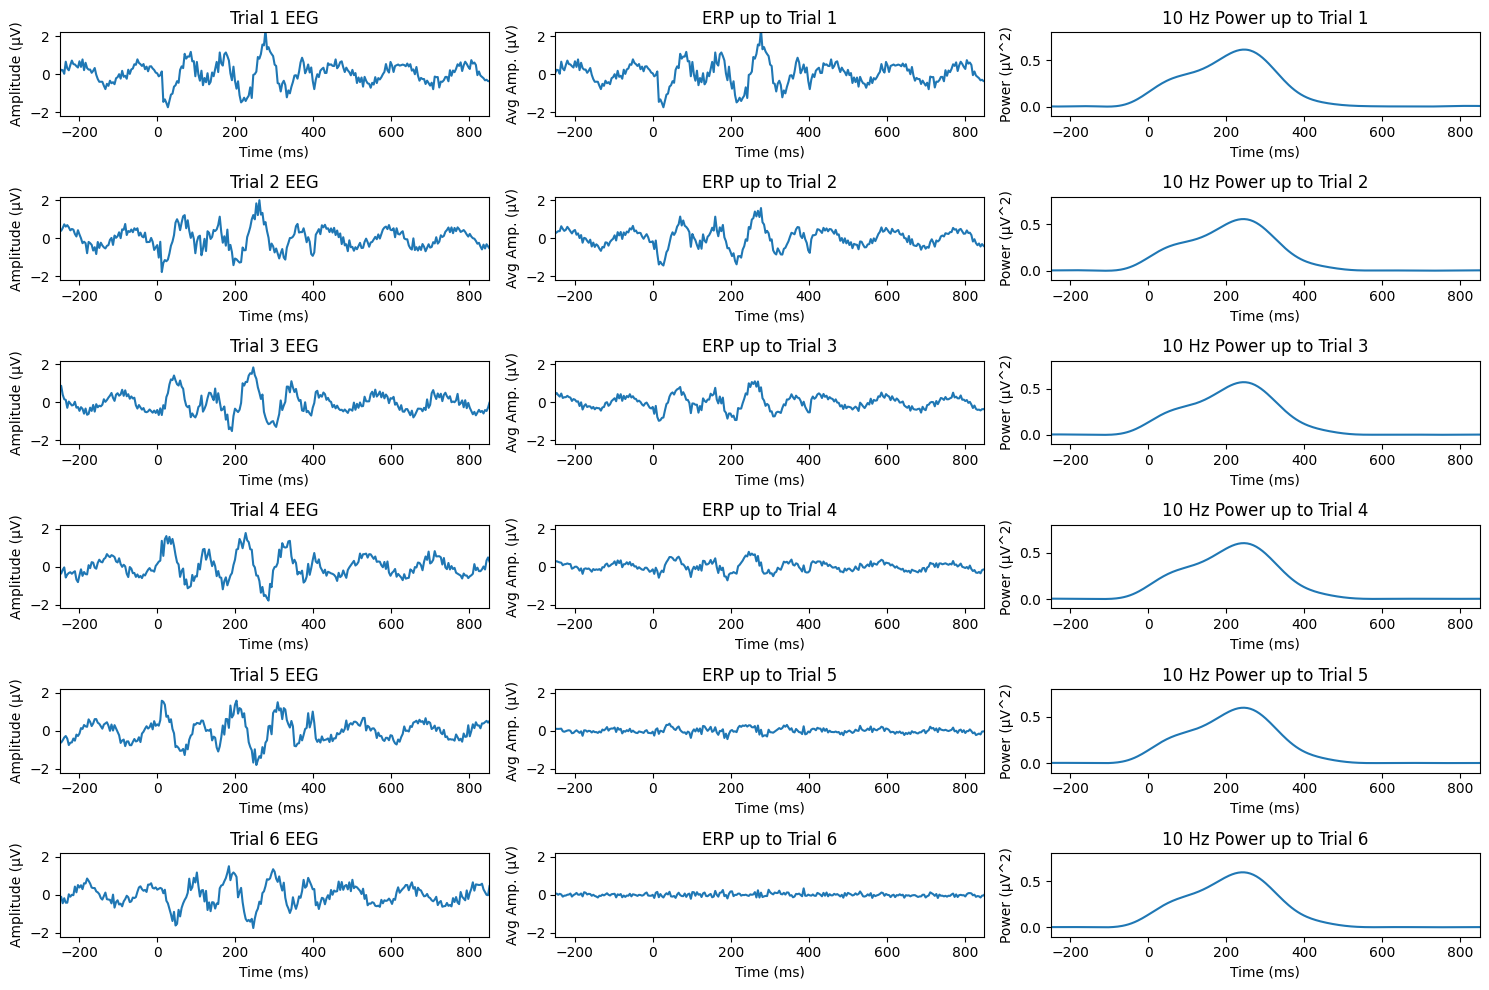

In [10]:
# Plotting setup
fig, axs = plt.subplots(nTrials, 3, figsize=(15, 10))

# Loop over trials
for triali in range(nTrials):
    
    # Create single trial "ERP"
    data[triali, :] = 0.5 * np.sin(2 * np.pi * 6 * EEG['times'][0] / 1000 + 2 * np.pi * triali / nTrials - np.pi) + np.random.randn(EEG['pnts'][0][0]) / 6
    # Add non-phase-locked stimulus potential
    data[triali, 259:360] = data[triali, 259:360] + np.sin(2 * np.pi * 10 * EEG['times'][0][259:360] / 1000 + 2 * np.pi * triali / nTrials - np.pi) + np.random.randn(101) / 5
    
    # Plot data from this trial
    axs[triali, 0].plot(EEG['times'][0], data[triali, :])
    axs[triali, 0].set_xlim([-250, 850])
    axs[triali, 0].set_ylim([-2.2, 2.2])
    axs[triali, 0].set_xlabel('Time (ms)')
    axs[triali, 0].set_ylabel('Amplitude (µV)')
    axs[triali, 0].set_title('Trial {0} EEG'.format(triali+1))
    
    # Plot ERP from trial 1 to current
    axs[triali, 1].plot(EEG['times'][0], np.mean(data[:triali+1, :], axis=0))
    axs[triali, 1].set_xlim([-250, 850])
    axs[triali, 1].set_ylim([-2.2, 2.2])
    axs[triali, 1].set_xlabel('Time (ms)')
    axs[triali, 1].set_ylabel('Avg Amp. (µV)')
    axs[triali, 1].set_title('ERP up to Trial {0}'.format(triali+1))
    
    # Convolve with 10 Hz wavelet
    convolution_result_fft = ifft(waveletfft * fft(data[triali, :], n_conv)) * np.sqrt(5 / (2 * np.pi * 10))
    convolution_result_fft = convolution_result_fft[int(np.floor(len(wavetime)/2)) : -int(np.floor(len(wavetime)/2))]
    data10hz[triali, :] = np.abs(convolution_result_fft)**2
    
    # Plot 10 Hz power
    axs[triali, 2].plot(EEG['times'][0], np.mean(data10hz[:triali+1, :], axis=0))
    axs[triali, 2].set_xlim([-250, 850])
    axs[triali, 2].set_ylim([-0.1, 0.8])
    axs[triali, 2].set_xlabel('Time (ms)')
    axs[triali, 2].set_ylabel('Power (µV^2)')
    axs[triali, 2].set_title('10 Hz Power up to Trial {0}'.format(triali+1))

plt.tight_layout()
plt.show()